<a href="https://colab.research.google.com/github/nsx07/word2vec-cbow/blob/main/CBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CBOW from Scratch

In [314]:
import numpy as np
import re

class CBOW:
    """
    Continuous Bag of Words (CBOW) model for learning word embeddings.

    Attributes:
        embedding_dim (int): Dimensionality of the word embeddings.
        window_size (int): Context window size.
        epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for weight updates.
        training_data (list): List of training sentences.
        vocab_size (int): Size of the vocabulary.
        vocab (list): List of unique words in the vocabulary.
        word_to_index (dict): Mapping from word to index.
        index_to_word (dict): Mapping from index to word.
        encoded_training_data (list): Encoded training data.
        embeddings (np.array): Word embedding matrix.
        output_weights (np.array): Output weight matrix.
    """

    def __init__(self, embedding_dim, window_size, epochs, learning_rate):
        """
        Initializes the CBOW model with the given parameters.
        Args:
            embedding_dim (int): Dimensionality of the word embeddings.
            window_size (int): Context window size.
            epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for weight updates.
        """
        self.embedding_dim = embedding_dim
        self.learning_rate = learning_rate
        self.window_size = window_size
        self.epochs = epochs

        # Attributes to be set during training
        self.encoded_training_data = None
        self.training_data = None
        self.word_to_index = None
        self.index_to_word = None
        self.vocab_size = None
        self.vocab = None

        # Weight matrices
        self.output_weights = None
        self.embeddings = None

    def separate_sentences(self, text):
        """
        Separates the input text into sentences based on punctuation.

        Args:
            text (str): Input text.

        Returns:
            list: List of sentences.
        """
        sentences = re.split(r'[.!?;]+', text)  # Split text into sentences
        sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # Remove empty strings and strip whitespace
        return sentences

    def create_vocabulary(self):
        """
        Creates the vocabulary from the training data.
        """
        all_words = re.sub(r'[^\w\s]', '', ' '.join(self.training_data).lower()).split()  # Remove punctuation and split into words
        self.vocab = sorted(set(all_words))  # Get unique words
        self.vocab_size = len(self.vocab)  # Size of the vocabulary
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocab)}  # Mapping from word to index
        self.index_to_word = {idx: word for word, idx in self.word_to_index.items()}  # Mapping from index to word

    def one_hot(self, word):
        """
        Creates a one-hot vector for a given word.

        Args:
            word (str): The word to encode.

        Returns:
            np.array: One-hot vector.
        """
        one_hot_vector = np.zeros(self.vocab_size)
        one_hot_vector[self.word_to_index[word]] = 1
        return one_hot_vector

    def encode_training_data(self):
        """
        Encodes the training data into pairs of onehot vector of target words and context words.
        """
        self.encoded_training_data = []

        for sentence in self.training_data:
            tokens = re.sub(r'[^\w\s]', '', sentence).lower().split()  # Tokenize and clean the sentence

            for word_pos, word in enumerate(tokens):
                target_word = self.one_hot(word)  # One-hot encode the target word
                context_words = []

                # Collect context words within the window size
                for context_pos in range(word_pos - self.window_size, word_pos + self.window_size + 1):
                    if 0 <= context_pos < len(tokens) and context_pos != word_pos:
                        context_words.append(tokens[context_pos])

                if context_words:
                    self.encoded_training_data.append((target_word, context_words))  # Add pair to the encoded training data

    def initialize_weights(self):
        """
        Initializes the weight matrices with random values.
        """
        self.embeddings = np.random.rand(self.vocab_size, self.embedding_dim)  # Word embedding matrix
        self.output_weights = np.random.rand(self.embedding_dim, self.vocab_size)  # Output weight matrix

    def softmax(self, x):
        """
        Computes the softmax of the input array.

        Args:
            x (np.array): Input array.

        Returns:
            np.array: Softmax probabilities.
        """
        exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
        return exp_x / np.sum(exp_x)

    def get_average_context_vector(self, context):
        """
        Computes the average context vector from the context words.

        Args:
            context (list): List of context words.

        Returns:
            np.array: Average context vector.
        """
        avg_vector = np.zeros(self.embedding_dim)
        for word in context:
            avg_vector += self.embeddings[self.word_to_index[word]]
        return avg_vector / len(context)  # Average the context vectors

    def compute_loss(self, y, y_pred):
        """
        Computes the cross-entropy loss between the true and predicted distributions.

        Args:
            y (np.array): True distribution (one-hot vector).
            y_pred (np.array): Predicted distribution (softmax output).

        Returns:
            float: Cross-entropy loss.
        """
        epsilon = 1e-10  # Small value to avoid log(0)
        return -np.sum(y * np.log(y_pred + epsilon))

    def update_weights(self, error, avg_context_vec, context):
        """
        Updates the weight matrices using backpropagation.

        Args:
            error (np.array): Error vector (y_pred - y).
            avg_context_vec (np.array): Average context vector.
            context (list): List of context words.
        """
        self.output_weights -= self.learning_rate * np.outer(avg_context_vec, error)  # Update output weights
        EH = np.dot(self.output_weights, error)  # Error for hidden layer
        for word in context:
            self.embeddings[self.word_to_index[word]] -= self.learning_rate * EH  # Update input embeddings

    def train(self, training_data):
        """
        Trains the CBOW model on the given training data.

        Args:
            training_data (str): Input text for training.
        """
        self.training_data = self.separate_sentences(training_data)  # Split text into sentences

        self.create_vocabulary()
        self.encode_training_data()
        self.initialize_weights()

        self.losses = []

        for epoch in range(self.epochs):
            total_loss = 0
            for target_word, context in self.encoded_training_data:
                avg_context_vec = self.get_average_context_vector(context)  # Compute average context vector
                scores = np.dot(avg_context_vec, self.output_weights)  # Compute scores
                y_pred = self.softmax(scores)  # Compute softmax probabilities

                error = y_pred - target_word  # Compute error
                total_loss += self.compute_loss(target_word, y_pred)  # Accumulate loss

                self.update_weights(error, avg_context_vec, context)  # Update weights

            self.losses.append(total_loss)

    def print_embeddings(self):
        """
        Prints the learned word embeddings.
        """
        if self.embeddings is None or self.vocab is None:
            print("The model has not been trained yet.")
            return

        for word, idx in self.word_to_index.items():
            print(f'{word}: {self.embeddings[idx]}')


### Parametros e execução

In [315]:
SOURCE = "Pierre, after all, had not managed to choose a career for himself in Petersburg, and had been expelled from there for riotous conduct and sent to Moscow. The story told about him at Count Rostóv’s was true. Pierre had taken part in tying a policeman to a bear. He had now been for some days in Moscow and was staying as usual at his father’s house. Though he expected that the story of his escapade would be already known in Moscow and that the ladies about his father—who were never favorably disposed toward him—would have used it to turn the count against him, he nevertheless on the day of his arrival went to his father’s part of the house. Entering the drawing room, where the princesses spent most of their time, he greeted the ladies, two of whom were sitting at embroidery frames while a third read aloud. It was the eldest who was reading—the one who had met Anna Mikháylovna. The two younger ones were embroidering: both were rosy and pretty and they differed only in that one had a little mole on her lip which made her much prettier. Pierre was received as if he were a corpse or a leper. The eldest princess paused in her reading and silently stared at him with frightened eyes; the second assumed precisely the same expression; while the youngest, the one with the mole, who was of a cheerful and lively disposition, bent over her frame to hide a smile probably evoked by the amusing scene she foresaw. She drew her wool down through the canvas and, scarcely able to refrain from laughing, stooped as if trying to make out the pattern."

LEARNING_RATE = 0.03
EMBEDDING_DIM = 10
WINDOW_SIZE = 4
EPOCHS = 300

w2v = CBOW(embedding_dim=EMBEDDING_DIM, learning_rate=LEARNING_RATE,
           window_size=WINDOW_SIZE, epochs=EPOCHS)

w2v.train(SOURCE)

### Gráficos 3D

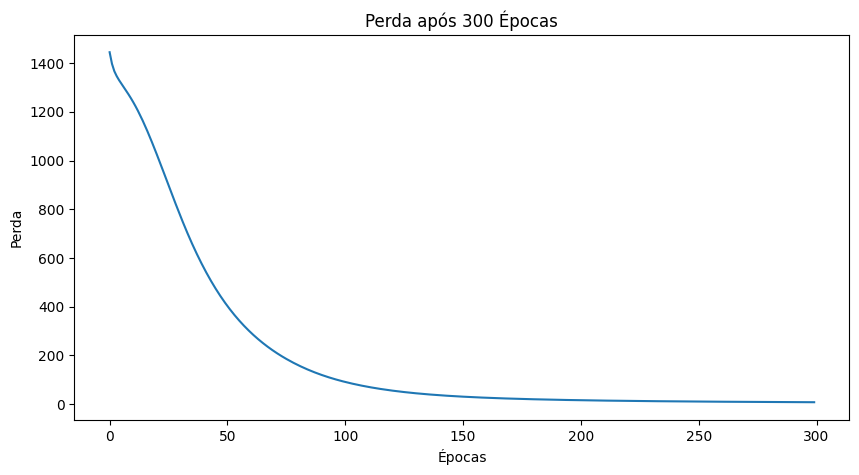

In [317]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Perda após {EPOCHS} Épocas')
ax.set_xlabel('Épocas')
ax.set_ylabel('Perda')
ax.plot(list(range(EPOCHS)), w2v.losses)
plt.show()

In [318]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio

def plot_embeddings_plotly(embeddings, vocab):
    pca = PCA(n_components=3)
    reduced_embeddings = pca.fit_transform(embeddings)
    data = [go.Scatter3d(
        x=[embedding[0] for embedding in reduced_embeddings],
        y=[embedding[1] for embedding in reduced_embeddings],
        z=[embedding[2] for embedding in reduced_embeddings],
        text=vocab,
        mode='markers+text',
        marker=dict(size=5, opacity=0.8),
        textposition="bottom center"
    )]

    layout = go.Layout(
        title="Representações de Palavras em 3D",
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )

    fig = go.Figure(data=data, layout=layout)
    pio.show(fig)

plot_embeddings_plotly(w2v.embeddings, w2v.vocab)

### Embeddings

In [313]:
w2v.print_embeddings()

cbow: [ 0.27873945  1.18600829  0.67122608  0.18456474  1.14366779  1.39353358
  0.11654648  0.55784044  0.26172133 -0.42215595]
de: [ 1.07287793 -0.68766858  1.17759777  1.06309015  1.52324086  0.27877163
  0.87376582  0.34989713  0.28310248  0.52301831]
este: [ 8.94174783e-01  1.00216777e-03  1.37660049e+00  2.72939542e-01
  2.62491229e-01  1.02944310e+00 -5.96224071e-02  2.77164912e-01
  8.93900475e-01  3.71835550e-01]
exemplo: [ 0.37006272  0.11628134  1.26548828  0.6640783   1.22619539  0.35363948
 -0.14712915  0.26065928  1.02739796  0.89153298]
modelo: [ 0.31486921  0.15497174 -0.84259473 -0.09791595  0.89734151  0.12012018
  0.58384589  0.13769416  1.72639948 -0.35535966]
o: [ 0.12140589  0.99979349  0.80437049  0.4432293  -0.79917557 -0.89382396
  1.47260404  1.11710282  1.1319621   0.6051672 ]
para: [-0.28888898  0.72827455 -0.96150922 -0.40951313  0.74569989  0.96831623
 -0.91810653  0.4741626  -0.1642701   1.71452898]
será: [ 1.24623737  0.6518842   0.7905364   1.3598848  -